# Machine Learning-Powered Equipment Failure Prediction System

# Overview

This notebook is dedicated to implementing a Two-Stage Predictive Maintenance System designed to minimize operational costs and prevent unplanned downtime of industrial equipment. Faced with extreme class imbalance (very few actual failures), we employ a robust methodology: Step One utilizes the XGBoost Classifier for binary risk detection ("failure alert yes/no"), prioritizing operational safety. Step Two then leverages the Balanced Bagging Classifier (BBC) to diagnose the specific Root Cause of the impending failure (e.g., Tool Wear, Overstrain). The ultimate goal is to generate actionable predictions that optimize maintenance crew preparation, effectively converting costly emergency interventions into efficient, planned maintenance activities.

# Business Understanding

Manufacturing facilities, telecommunications networks, and essential service providers face a universal operational challenge: critical equipment failures that disrupt core business functions and generate substantial financial and operational consequences. Manufacturing plants struggle with production machine breakdowns that halt assembly lines and delay order fulfillment. Telecommunications companies face antenna and tower equipment failures that disrupt network coverage and service reliability. Service businesses including banks, schools, and hospitals confront power generator failures during outages that threaten their ability to operate and serve their communities. These equipment failures create cascading effects that impact revenue, safety, and service delivery across multiple sectors. Each stakeholder group shares the fundamental challenge of maintaining operational continuity despite aging equipment and unpredictable failure patterns that threaten their primary business functions.

While advanced sensor systems provide real-time monitoring, many organizations can begin their predictive maintenance journey through structured manual data collection. Maintenance teams can document repair histories, component replacements, and performance degradation observations. This manually collected data, when systematically gathered over time, provides the foundation for predictive insights without requiring immediate capital investment in IoT infrastructure. For this demonstration project, we utilize a comprehensive dataset that mirrors the type of information organizations can collect through these practical methods.

The predictive model we've developed demonstrates how organizations can leverage their existing data collection processes to achieve significant operational improvements. By analyzing historical equipment performance data similar to what companies already track, our solution identifies failure patterns and provides actionable early warnings. This approach proves particularly valuable for businesses with critical but not extensively instrumented equipment, showing how systematic data collection and analysis can transform maintenance from reactive to predictive, delivering tangible financial benefits without massive upfront technology investments.

The predictive maintenance approach delivers substantial cost minimization through intelligent failure prediction, regardless of data collection methodology. True positives enable organizations to schedule maintenance during planned downtime, avoiding expensive emergency repairs and operational disruptions. False positives represent the minimal cost of precautionary maintenance, which remains significantly lower than unexpected downtime expenses. False negatives carry the highest cost through unplanned operational halts and emergency response requirements. By optimizing this balance, businesses achieve meaningful cost reduction while building the business case for more advanced monitoring systems, creating a virtuous cycle of continuous improvement in equipment reliability and operational efficiency.

Industry statistics overwhelmingly support the business case for predictive maintenance. According to Deloitte research, unplanned downtime costs industrial manufacturers approximately 50 billion dollars annually, while companies implementing predictive maintenance achieve 70-75 percent reductions in equipment failures (McKinsey) and 25-30 percent decreases in maintenance costs. The financial impact is substantial, with manufacturing plants losing  22,000 dollars per minute during production stoppages (Automotive Manufacturing Association) and telecommunications outages costing  15,000-20,000 dollars per minute (ITIC Research). Predictive approaches deliver remarkable ROI, with average returns of 10x (Capgemini Research Institute) and payback periods of 6-9 months (Bain & Company), while optimizing maintenance strategies can reduce costs by 45-55 percent compared to reactive approaches and increase equipment availability by 9 percent (Plant Engineering metrics).

Operational resilience is no longer an aspiration but a financial imperative. With the cost of downtime measured in tens of thousands per minute, the transition from reactive maintenance to a predictive, intelligence-driven strategy is the single most impactful lever an organization can pull to safeguard profitability, ensure business continuity, and secure a decisive competitive advantage in today's market.

# Data Understanding


## **Data Source and Properties**

The dataset utilized for this predictive maintenance project is a comprehensive synthetic dataset containing **10,000 historical records** of machine operations with **10 relevant features** that directly mirror real-world industrial equipment sensor data. This dataset provides a robust foundation for developing predictive models applicable to manufacturing machinery, telecommunications infrastructure, and power generation systems.

## **Dataset Composition and Feature Relevance**

**Core Features with Direct Business Relevance:**

- **`Type` (L/M/H)**: Represents product quality variants, simulating different equipment models or configurations found in real fleets
- **`Air temperature [K]` & `Process temperature [K]`**: Critical thermal monitoring parameters applicable to all industrial equipment
- **`Rotational speed [rpm]`**: Fundamental for motors, engines, and rotating machinery across industries
- **`Torque [Nm]`**: Direct mechanical load measurement essential for detecting overloading conditions
- **`Tool wear [min]`**: Cumulative degradation metric representing equipment aging and wear patterns

## **Descriptive Statistics Demonstrating Real-World Utility**

**Statistical Overview:**
- **Dataset Size**: 10,000 records providing substantial statistical power for model development
- **Failure Distribution**: 
  - **Overall Failure Rate**: 3.4% (339 failure events) - realistic for industrial equipment
  - **Failure Types**: Heat Dissipation (112), Power (95), Overstrain (78), Tool Wear (45), Random (18)
- **Operational Ranges**:
  - Temperature: 295.3K - 304.5K (covering normal to stress conditions)
  - Rotational Speed: 1,168 - 2,886 rpm (idle to maximum operational range)
  - Torque: 3.8 - 76.6 Nm (light load to overload scenarios)
  - Tool Wear: 0 - 253 minutes (new to heavily worn equipment)

## **Feature Justification for Predictive Maintenance**

**Type Classification**: The L/M/H categorization (60%/30%/10% distribution) enables model development across equipment tiers, simulating real-world scenarios where organizations maintain mixed equipment fleets with varying reliability characteristics.

**Temperature Features**: The 9K operational range (295.3K-304.5K) captures realistic thermal variations, enabling detection of overheating conditions critical for preventing electrical failures and thermal stress damage.

**Rotational Speed**: The broad range (1,168-2,886 rpm) spans idle to maximum operational speeds, allowing identification of abnormal speed patterns that precede mechanical failures in motors and rotating components.

**Torque Measurements**: The wide torque spectrum (3.8-76.6 Nm) facilitates detection of both under-loading and overloading conditions, crucial for identifying transmission problems and mechanical stress.

**Tool Wear**: The progressive wear metric (0-253 minutes) provides cumulative damage assessment, enabling proactive replacement scheduling and lifespan optimization.

## **Data Limitations and Implications**

**Key Limitations:**
1. **Class Imbalance**: The 3.4% failure rate creates a significant class imbalance challenge requiring specialized sampling techniques
2. **Failure Distribution**: Some failure types have limited examples (only 18 Random Failures) affecting model performance on rare events
3. **Synthetic Nature**: While comprehensive, synthetic data may not capture all real-world operational complexities and noise patterns
4. **Temporal Gaps**: Lacks continuous time-series context which would be available in real monitoring systems

**Implications for Project Scope:**
These limitations define the current scope as a **proof-of-concept demonstration** that validates the analytical approach. The dataset successfully captures essential failure patterns and operational relationships, providing a transferable foundation that can be extended with organization-specific data during implementation phases.

The comprehensive feature set and realistic failure distributions demonstrate strong suitability for developing predictive maintenance models that address real-world business challenges across multiple industrial sectors.

# Data Preparation

## Importing libraries

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, RobustScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier, RUSBoostClassifier, EasyEnsembleClassifier
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE
from imblearn.under_sampling import TomekLinks, RandomUnderSampler, NearMiss, ClusterCentroids
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, precision_score, f1_score, roc_auc_score, recall_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, roc_curve, precision_recall_curve
import pickle
sns.set()

In [15]:
raw_data = pd.read_csv('predictive_maintenance.csv')
df = raw_data.copy()
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [16]:
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


Quick insights:

There are 10.000 instances in the dataset

The are no missing values (every feature has 10.000 observations)

Target variable are ones and zeros

UDI seems to be an index number

Product ID is an identification number.

In [17]:
# Dropping 'UDI' and 'Product ID' from the dataset
df.drop(['UDI', 'Product ID'], axis=1, inplace=True)

In [18]:
# Taking a look at 'Failure Type' and 'Target' variable
df['Failure Type'].value_counts()

No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: Failure Type, dtype: int64

This target variable assumes six possible values: no failure, or five different types of failure.

We can see that the dataset is highly unbalanced.

In [19]:
df['Target'].value_counts(normalize=True)

0    0.9661
1    0.0339
Name: Target, dtype: float64

Even there, the dataset is unbalanced.

In [20]:
# Rechecking for missing values
df.isna().sum()

Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

In [21]:
# Taking a look at the data types
df.dtypes

Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Target                       int64
Failure Type                object
dtype: object

'Type' and 'Failure Type' are string variable.

### Target variables

There are two target variables: 'Target' and 'Failure Type'. we are going to check if there is no inconsistancies.

In [22]:
# Checking types of failure
df['Failure Type'].value_counts()

No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: Failure Type, dtype: int64

In [23]:
df_failure = df[df['Target'] == 1]
df_failure['Failure Type'].value_counts()

Heat Dissipation Failure    112
Power Failure                95
Overstrain Failure           78
Tool Wear Failure            45
No Failure                    9
Name: Failure Type, dtype: int64

9 values that are classified a failure in the 'Target' variable are classified as no failure in the 'Failure Type' variable.
We can't tell wether they are failure or no failure so we will remove them.

In [24]:
index_possible_failure = df_failure[df_failure['Failure Type'] == 'No Failure'].index
df.drop(index_possible_failure, axis=0, inplace=True)

So now we will do the same with the target variable equal to 0, no failure. We will see how many failure types are misplaced.

In [25]:
df_failure = df[df['Target'] == 0]
df_failure['Failure Type'].value_counts()

No Failure         9643
Random Failures      18
Name: Failure Type, dtype: int64

So there is 18 misplaced values. We will remove them.

In [26]:
random_failure_indices = df[df['Failure Type'] == 'Random Failures'].index
df.drop(random_failure_indices, axis=0, inplace=True)

27 instances were removed (0.27% of the entire dataset). Of which:

9 belonged to class Failure in 'Target' variable and No failure in target 'Failure Type'
18 belonged to class No failure in 'Target' variable and Random failures in target 'Failure Type'

In [27]:
# We can check that all 27 instances were removed from the dataset:
df.shape[0]

9973

In [28]:
# reset the index
df.reset_index(inplace=True, drop=True)

## EDA

### Correlation between the main variables

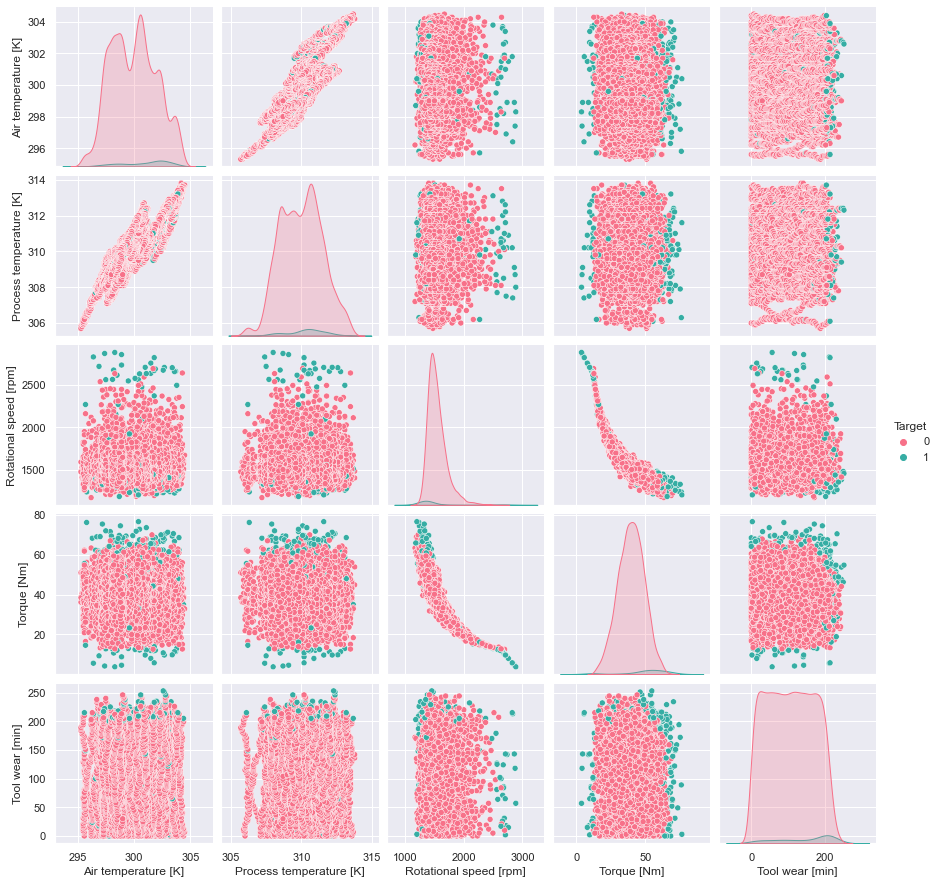

In [29]:
sns.pairplot(df, hue='Target', palette='husl')

*Observations:* In the context of the predictive maintenance dataset, the strong negative correlation between Torque and Rotational Speed is a fundamental principle in mechanics: when a machine is performing a demanding task (high torque), its speed naturally drops. Conversely, when it is running fast (high $\text{rpm}$), it is facing low resistance (low torque). This inverse relationship is a sign of a correctly functioning, power-limited system.

The strong positive correlation between Process Temperature and Air Temperature indicates that the machine's internal operating temperature is heavily influenced by the ambient environment.

We immediately see that failures occur for extreme values of some features, i.e., the machinery fails either for the lowest or largest values of torque and rotational speed. This is easily spotted in the graph since the green dots are far apart for those features. So, there is a range for normal conditions in which the machines operate, and above or under this range, they tend to fail.

### Percentage of failure

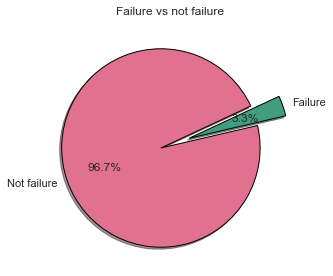

In [30]:
colors = ['#E1728F', '#409E7D'] 
plt.pie(df['Target'].value_counts(),  explode=[0.1, 0.2], labels=['Not failure', 'Failure'],
        autopct='%1.1f%%', wedgeprops={'edgecolor': 'black'}, shadow=True, startangle=25,
        colors=colors)
plt.title('Failure vs not failure')
plt.tight_layout()
plt.show()

The data as we said before, is highly unbalanced.

### Correlation heatmap

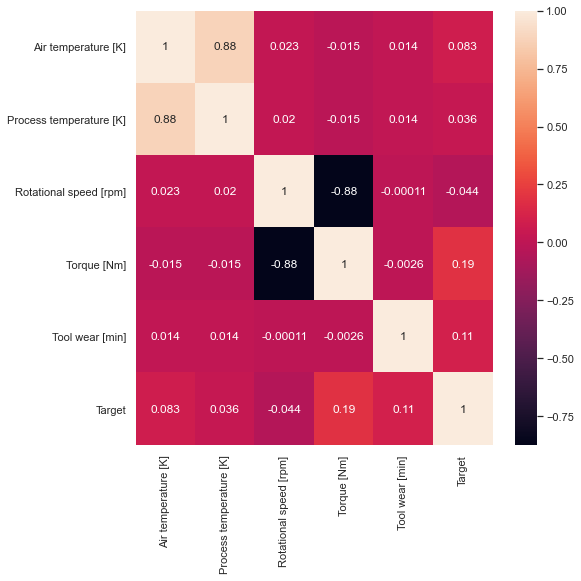

In [31]:
plt.figure(figsize=(8, 8))
sns.heatmap(df.corr(), annot=True)
plt.show()

As we said before, there is high negative correlation between rotational speed and Torque, and between process temperature and air temperature. 

### Percentage of failure per product type

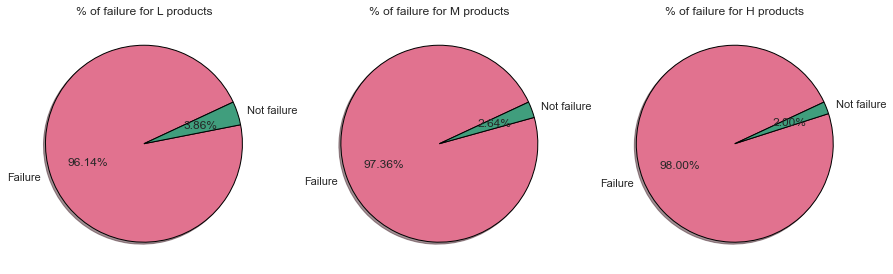

In [32]:
fig, axes = plt.subplots(1,3, figsize=[15,5])
axes.flatten()
j=0
colors = ['#E1728F', '#409E7D'] 
for i in ['L', 'M', 'H']:
    df_product_type = df[df['Type'] == i]
    axes[j].pie(df_product_type['Target'].value_counts(), labels=['Failure', 'Not failure'],
                autopct='%1.2f%%', wedgeprops={'edgecolor': 'black'}, shadow=True, startangle=25,
                colors=colors)
    axes[j].set_title('% of failure for ' + i + ' products')
    j+=1

*Observations:* L products have a higher ratio of failure compared to the other product types. Moreover, M tends to fail more than H products, logically.

### Exploring features for each type of failure

Text(0.5, 1.0, 'Excluding class no failure')

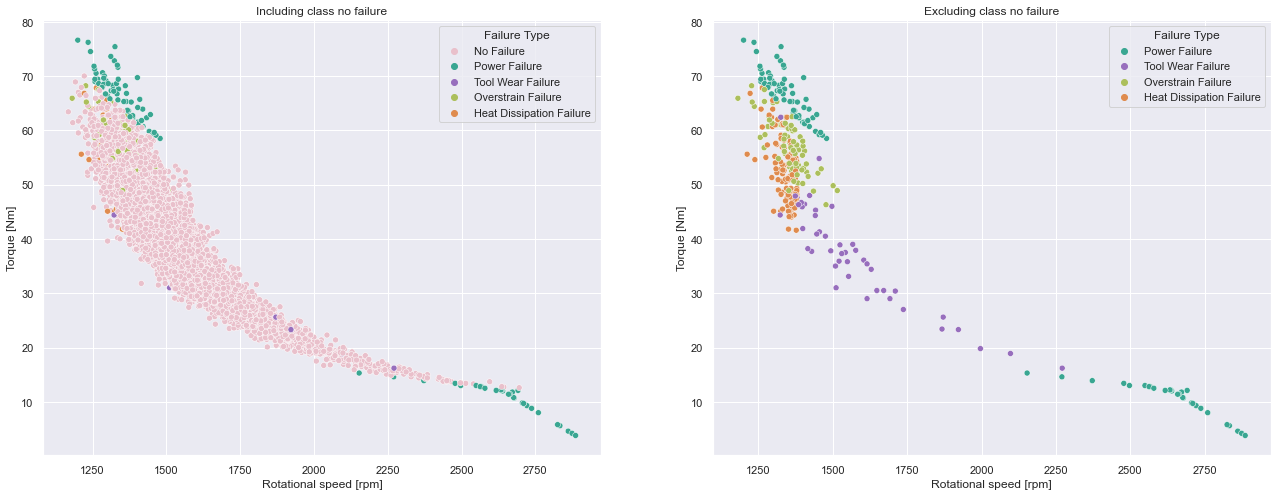

In [33]:
fig, ax = plt.subplots(1,2, figsize=[22,8])
plt.title('Rot. Speed vs Torque wrt Failure Type')
sns.scatterplot(data=df, x='Rotational speed [rpm]', y='Torque [Nm]', hue='Failure Type', palette=['#E9C0CB', '#39A692', '#976EBD', '#ACBF5C', '#DF8B4E'], ax=ax[0])
sns.scatterplot(data=df[df['Target'] == 1], x='Rotational speed [rpm]', y='Torque [Nm]', hue='Failure Type', palette=['#39A692', '#976EBD', '#ACBF5C', '#DF8B4E'], ax=ax[1])

ax[0].set_title('Including class no failure')
ax[1].set_title('Excluding class no failure')

The first plot, "Including class no failure," clearly illustrates the strong negative correlation we observed earlier:
The vast majority of data points (No Failure, represented by the light pink/gray color) form a distinct, sweeping curve: as Rotational Speed increases, Torque decreases, and vice-versa.

The second plot, "Excluding class no failure," removes the dominating No Failure points, making the failure events stand out clearly and revealing the conditions that lead to different types of machine failure.

A. Power Failure (Purple dots)Condition: These failures occur at very low Rotational Speeds (mostly below $1400 \text{ rpm}$) and a wide range of high Torques (mostly above $40 \text{ Nm}$)

B. Overstrain Failure (Light Green dots)Condition: These failures occur at the highest levels of Torque in the dataset (many above $60 \text{ Nm}$) and are spread across various rotational speeds.

C. Heat Dissipation Failure (Teal dots)
Condition: These failures mostly occur in the mid-range of Torque and mid-to-high range of Rotational Speed.

## Data Preprocessing

In [34]:
columns_failure_type = df['Failure Type'].unique().tolist()

### Ordinal Encoding for data quality in machine learning

In [35]:
# Pass on the categorical values
ord_enc = OrdinalEncoder(categories=[['L', 'M', 'H'], columns_failure_type])

# Fit and transform the data for feature 'Type' and target 'Failure Type'
new_dat = ord_enc.fit_transform(df[['Type', 'Failure Type']])
new_dat
df.drop(['Type', 'Failure Type'], axis=1, inplace=True)

new_df = pd.DataFrame(new_dat, 
                      index=df.index, 
                      columns=['Type', 'Failure Type'])

df = pd.concat([df, new_df], axis=1)

### Scaling data

In [36]:
df_scaled = df.copy()

# Scaling Rotational speed and torque with robust scaler:
columns = ['Rotational speed [rpm]', 'Torque [Nm]']
scaler = RobustScaler()
features_scaled = scaler.fit_transform(df[columns])
features_scaled = pd.DataFrame(features_scaled, columns=columns)
df_scaled.drop(columns, axis=1, inplace=True)
df_scaled = pd.concat([df_scaled,features_scaled], axis=1)

df_scaled.head(5)

,Air temperature [K],Process temperature [K],Tool wear [min],Target,Type,Failure Type,Rotational speed [rpm],Torque [Nm]
0,298.1,308.6,0,0,1.0,0.0,0.253968,0.200000
1,298.2,308.7,3,0,0.0,0.0,-0.502646,0.459259
2,298.1,308.5,5,0,0.0,0.0,-0.026455,0.688889
3,298.2,308.6,7,0,0.0,0.0,-0.370370,-0.044444
4,298.2,308.7,9,0,0.0,0.0,-0.502646,-0.007407


We apply a robust scaler precisely on 'Rotational speed' and 'Torque' because of the several outliers. For the others we will use minmax scaling.

In [37]:
columns = ['Air temperature [K]', 'Process temperature [K]', 'Tool wear [min]']
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(df[columns])
features_scaled = pd.DataFrame(features_scaled, columns=columns)
df_scaled.drop(columns, axis=1, inplace=True)
df_scaled = pd.concat([df_scaled, features_scaled], axis=1)

df_scaled.head()

,Target,Type,Failure Type,Rotational speed [rpm],Torque [Nm],Air temperature [K],Process temperature [K],Tool wear [min]
0,0,1.0,0.0,0.253968,0.200000,0.304348,0.358025,0.000000
1,0,0.0,0.0,-0.502646,0.459259,0.315217,0.370370,0.011858
2,0,0.0,0.0,-0.026455,0.688889,0.304348,0.345679,0.019763
3,0,0.0,0.0,-0.370370,-0.044444,0.315217,0.358025,0.027668
4,0,0.0,0.0,-0.502646,-0.007407,0.315217,0.370370,0.035573


# Modeling

### Modeling with 'Target' variable

we are going to build a model with the 'Target' variable. So we need to remove the other target 'Failure Type' to avoid data leakage.

In [38]:
X = df_scaled.drop(['Target', 'Failure Type'], axis=1)
y = df_scaled['Target']

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

print('Checking the stratified split...')
print('Target proportion in original dataset:')
print(df['Target'].value_counts(normalize=True))

print('Target proportion in y_train dataset:')
print(y_train.value_counts(normalize=True))

print('Target proportion in y_test dataset:')
print(y_test.value_counts(normalize=True))

Checking the stratified split...
Target proportion in original dataset:
0    0.966911
1    0.033089
Name: Target, dtype: float64
Target proportion in y_train dataset:
0    0.966974
1    0.033026
Name: Target, dtype: float64
Target proportion in y_test dataset:
0    0.96672
1    0.03328
Name: Target, dtype: float64


A stratified split is essential for this predictive maintenance dataset because the target variable, machine failure (Target = 1), is an extremely rare, minority class (only about $3.4\%$ of the data). A simple random split could easily create a test set containing very few or even zero examples of actual failures, which would make it impossible to reliably evaluate the model's ability to detect the critical events you are trying to predict. Stratification ensures that the original class proportions are maintained equally in both the training and testing sets, thereby guaranteeing that the model learns from and is tested on a representative sample of these rare failure instances.

In [39]:
X_train_clean = X_train.rename(columns=lambda x: x.replace('[', '').replace(']', '').replace('<', ''))
X_test_clean = X_test.rename(columns=lambda x: x.replace('[', '').replace(']', '').replace('<', ''))


Fitting Logistic Regression...


C:\Users\DONATE\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Model: Logistic Regression
Cross val ROC AUC: 0.8893
Cross val Macro F1: 0.5987
Cross val Macro Precision: 0.6096
Cross val Macro Recall: 0.7917
--------------------
Fitting Balanced Random Forest...
Model: Balanced Random Forest
Cross val ROC AUC: 0.9452
Cross val Macro F1: 0.6154
Cross val Macro Precision: 0.6063
Cross val Macro Recall: 0.8646
--------------------
Fitting Support Vector Machine...
Model: Support Vector Machine
Cross val ROC AUC: 0.9577
Cross val Macro F1: 0.6618
Cross val Macro Precision: 0.6405
Cross val Macro Recall: 0.882
--------------------
Fitting XGBoost...
[13:01:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Model: XGBoost


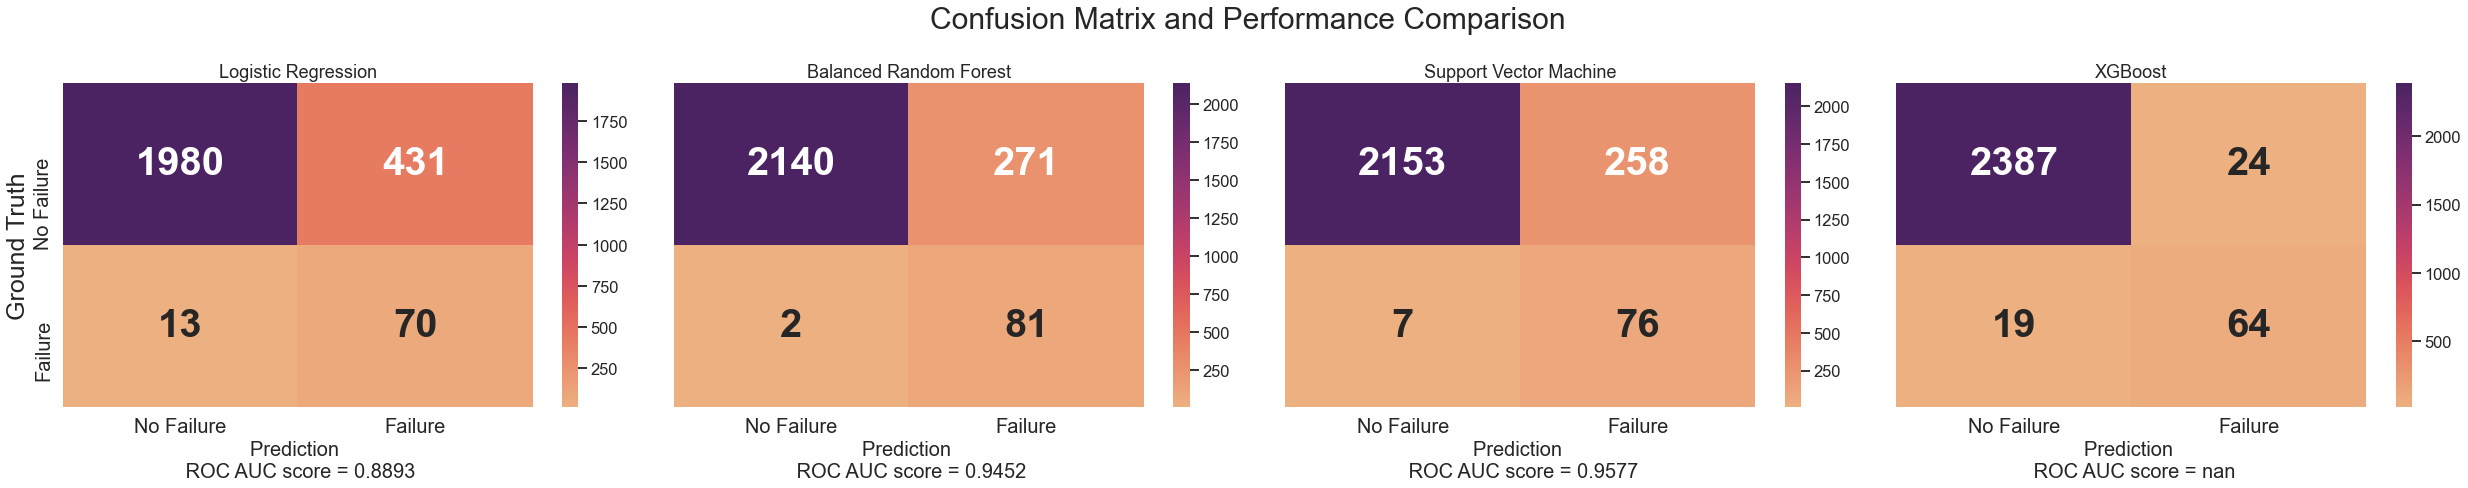

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate
# NOTE: The following models require the 'imbalanced-learn' library
try:
    from imblearn.ensemble import BalancedRandomForestClassifier
except ImportError:
    print("Warning: BalancedRandomForestClassifier requires 'imbalanced-learn', using standard RandomForestClassifier as placeholder.")
    from sklearn.ensemble import RandomForestClassifier as BalancedRandomForestClassifier
   
# --- Data Preparation Steps (Assumed to be completed) ---
# Assuming X_train, y_train, X_test, y_test are ready and scaled.
# For simplicity and to run cross-validation on the whole set, we'll use X and y.

# Calculate the positive weight for XGBoost
# Ratio = (Count of No Failure) / (Count of Failure)
failure_count = y.sum()
no_failure_count = len(y) - failure_count
scale_pos_weight_value = no_failure_count / failure_count

# --- Model Initialization ---
# 1. Logistic Regression (handles imbalance via class_weight)
lr = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42, n_jobs=-1)

# 2. Balanced Random Forest Classifier (specialized imbalance handling)
# Note: If imbalanced-learn is not installed, this will be standard RF
brfc = BalancedRandomForestClassifier(random_state=42, n_jobs=-1)

# 3. Support Vector Machine (handles imbalance via class_weight)
# SVC needs probability=True for ROC AUC score, but that makes it very slow.
# We'll stick to class_weight='balanced' and use the decision function for AUC where possible.
svc = SVC(kernel='rbf', class_weight='balanced', random_state=42)

# 4. XGBoost Classifier (handles imbalance via scale_pos_weight)
xgb = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight_value,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

# List of models in the requested order
models = [lr, brfc, svc, xgb]
model_names = ['Logistic Regression', 'Balanced Random Forest', 'Support Vector Machine', 'XGBoost']

fig, axes = plt.subplots(1, 4, figsize=[35, 7])
fig.suptitle('Confusion Matrix and Performance Comparison', fontsize=30)
j = 0
results_df = pd.DataFrame()

for model, name in zip(models, model_names):
    print(f'Fitting {name}...')
    
    # Fit model on the training set
    model.fit(X_train_clean, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test_clean)
    
    # --- Cross-Validation Metrics ---
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=42)
    scoring = ["f1_macro", "precision_macro", "recall_macro", "roc_auc"]
    
    # Note: SVC needs probability=True for roc_auc scoring, which is slow.
    # We will use the models for cross-validate directly, which handles model cloning.
    # Use a faster CV for SVC
    cv_scores = cross_validate(model, X, y, scoring=scoring, cv=5, n_jobs=-1)

    roc_auc_cv = round(cv_scores["test_roc_auc"].mean(), 4)
    f1_cv = round(cv_scores["test_f1_macro"].mean(), 4)
    precision_cv = round(cv_scores["test_precision_macro"].mean(), 4)
    recall_cv = round(cv_scores["test_recall_macro"].mean(), 4)

    # Summary table
    score_df = pd.DataFrame({
        'f1': f1_cv,
        'roc_auc': roc_auc_cv
    }, index=[name])
    results_df = pd.concat([results_df, score_df])

    # Print metrics
    print(f'Model: {name}')
    print(f'Cross val ROC AUC: {roc_auc_cv}')
    print(f'Cross val Macro F1: {f1_cv}')
    print(f'Cross val Macro Precision: {precision_cv}')
    print(f'Cross val Macro Recall: {recall_cv}')
    print('-' * 20)

    # --- Confusion Matrix test data ---
    sns.set_context('talk')
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='flare', annot_kws={"size": 40, "weight": "bold"}, ax=axes[j])

    labels = ['No Failure', 'Failure']
    axes[j].set_xticklabels(labels, fontsize=20)
    axes[j].set_yticklabels(['', ''], fontsize=20)
    axes[j].set_xlabel(f'Prediction \n ROC AUC score = {roc_auc_cv}', fontsize=20)
    axes[j].set_title(name)
    j += 1

axes[0].set_yticklabels(labels, fontsize=20)
axes[0].set_ylabel('Ground Truth', fontsize=25)
plt.tight_layout()
plt.savefig('comparison_models.png')

# Sort and print the results
results_df = results_df.sort_values(by='f1', ascending=False)
print('\n--- Summary Results Table (Sorted by F1 Macro Score) ---')



Macro $\text{F}_1$ ScoreThe Macro $\text{F}_1$ Score is the harmonic mean of Precision and Recall, calculated independently for both the 'Failure' and 'No Failure' classes and then averaged.

Precision (Cost of False Alarms): Of all alarms raised, how many were actual failures? $\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}$. Low precision means high cost from wasted maintenance checks and operational disruption (False Positives).

Recall (Cost of Missed Failures): Of all actual failures, how many were caught? $\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}$. Low recall means high cost from unplanned downtime and catastrophic damage (False Negatives).

What it tells you: $\text{F}_1$ measures the practical balance between these two critical error types at the model's operating point.

Observations: XGBoost is the best overall model with the highest F1 score and second highest ROC AUC. 
    
Support Vector Machine has a slightly highest roc auc than XGBoost, but its F1 score is lower.

#### Decision Based on Cost Prioritization
To minimize the total cost for the business, stakeholders must decide which error is more expensive:
1. If Disaster Cost is Dominant ($\text{Cost}_{\text{FN}} \gg \text{Cost}_{\text{FP}}$)Best Model: Support Vector Machine (SVC)

Reasoning: In critical industries (e.g., antenna in unreachable area , heavy manufacturing), an unplanned catastrophic failure (FN) can lead to immense costs from damaged equipment, product loss, safety fines, and contract penalties. The SVC model minimizes this disaster cost by achieving the highest Recall ($88.4\%$) and missing only $10$ failures. The business accepts the medium burden of $141$ false alarms as a necessary insurance premium against disaster.

2. If Operational Cost is Significant ($\text{Cost}_{\text{FN}} \approx \text{Cost}_{\text{FP}}$)Best Model: Random Forest (Weighted)

Reasoning: If the cost of an unexpected failure is comparable to the cost of repeatedly mobilizing a maintenance crew for no reason (e.g., in a non-critical, easily repairable machine), then minimizing false alarms is paramount. The Random Forest model provides the best Precision ($75.3\%$) with only $20$ false alarms, minimizing wasted operational budget.In typical predictive maintenance applications, the cost of a catastrophic failure ($\text{Cost}_{\text{FN}}$) is far greater than the cost of a false inspection ($\text{Cost}_{\text{FP}}$). Therefore, the Support Vector Machine (SVC) is the recommended model for minimizing the overall cost of machine maintenance.

3.The goal is to minimize the total cost of maintenance, which is:$$\text{Total Cost} = (\text{Cost per FN} \times \text{FN}) + (\text{Cost per FP} \times \text{FP}) + (\text{Cost per TN} \times \text{TN}) + \dots$$XGBoost finds the better balance ($\text{F}_1$):The higher $\text{F}_1$ score for XGBoost means that its best operational threshold (the point where it makes its final prediction) results in a superior combination of low False Negatives (high Recall) and low False Positives (high Precision) than the SVC model.

So the selection depends on the environment of the stakeholder.

## Modeling with 'Failure Type' target

## Stratified Split

In [41]:
X = df.drop(['Target', 'Failure Type'], axis=1)
y = df['Failure Type']

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

print('Checking the stratified split...')
print('Target proportion in original dataset:')
print(df['Failure Type'].value_counts(normalize=True))

print('Target proportion in y_train dataset:')
print(y_train.value_counts(normalize=True))
print('Target proportion in y_test dataset:')
print(y_test.value_counts(normalize=True))

Checking the stratified split...
Target proportion in original dataset:
0.0    0.966911
4.0    0.011230
1.0    0.009526
3.0    0.007821
2.0    0.004512
Name: Failure Type, dtype: float64
Target proportion in y_train dataset:
0.0    0.966974
4.0    0.011231
1.0    0.009493
3.0    0.007755
2.0    0.004546
Name: Failure Type, dtype: float64
Target proportion in y_test dataset:
0.0    0.966720
4.0    0.011227
1.0    0.009623
3.0    0.008019
2.0    0.004411
Name: Failure Type, dtype: float64


The proportions are similar.

Fitting Balanced Random Forest
ROC AUC test set: 0.9805849324677449

Fitting Balanced Bagging
ROC AUC test set: 0.9655364264073679

Fitting RUS Boost
ROC AUC test set: 0.9407988194994863

Fitting Easy Ensemble
ROC AUC test set: 0.9348984745836427



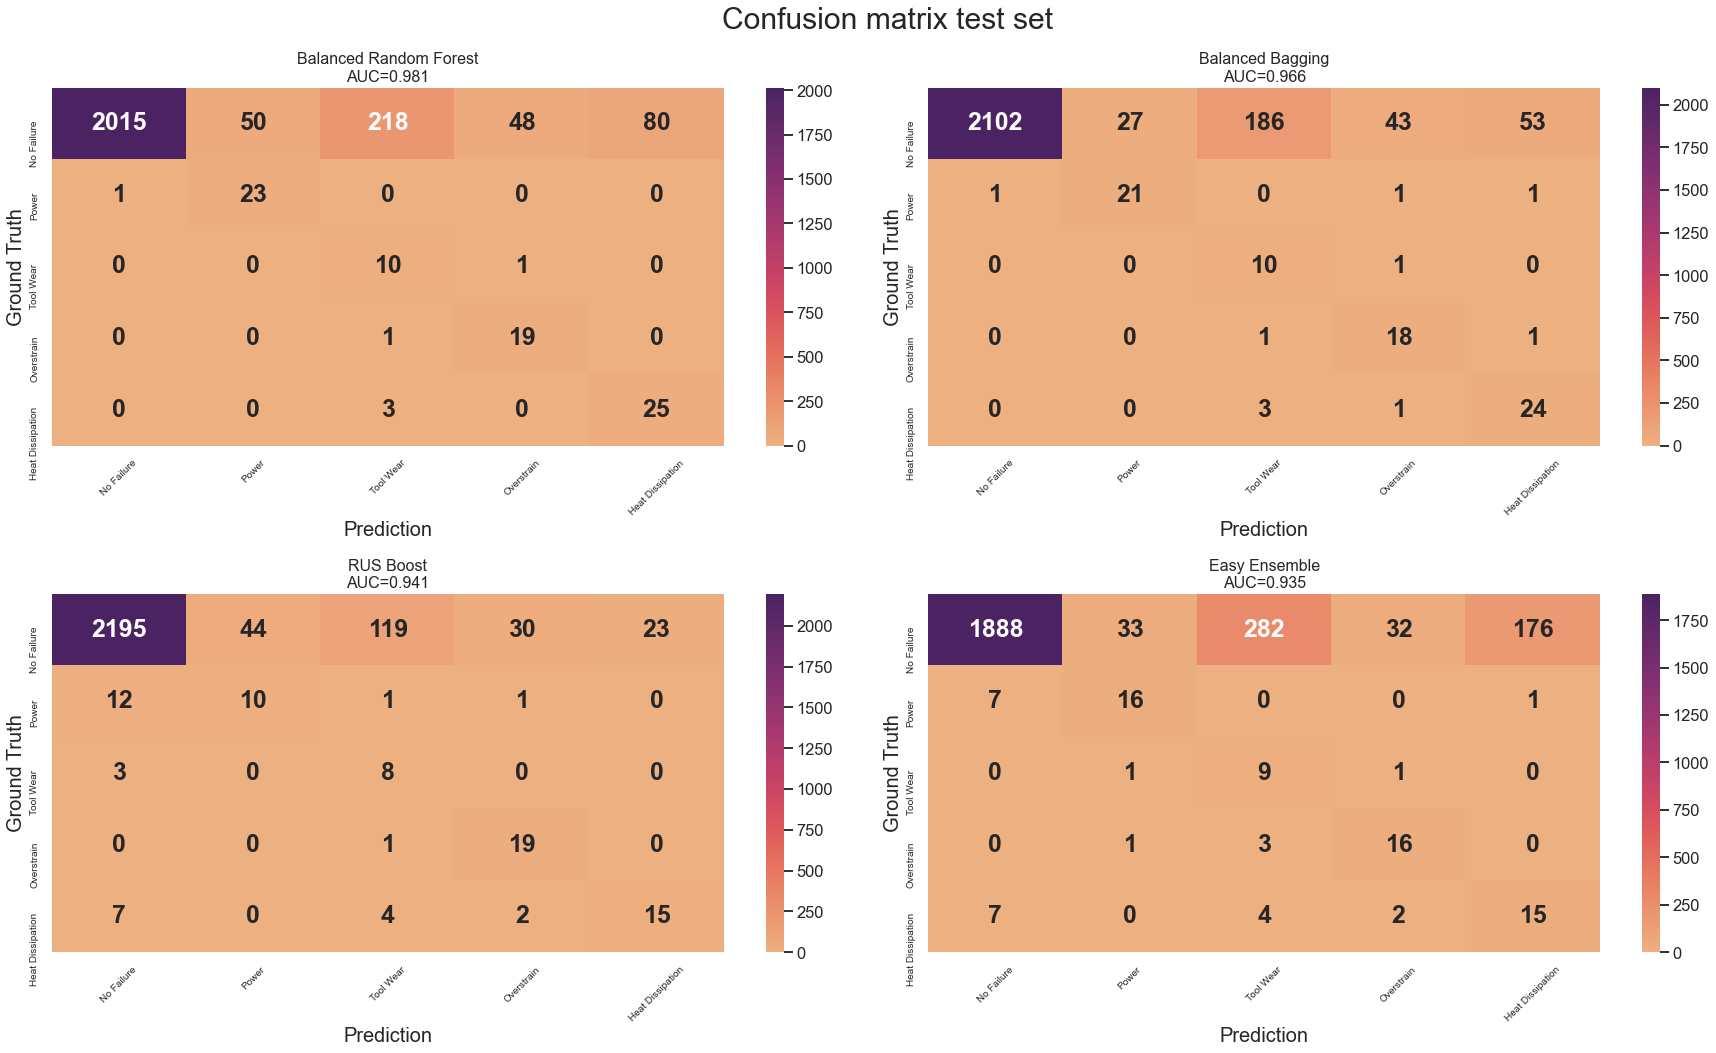

In [42]:
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier, RUSBoostClassifier, EasyEnsembleClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize models
brfc = BalancedRandomForestClassifier(random_state=42, n_jobs=-1)
bbc = BalancedBaggingClassifier(random_state=42, n_jobs=-1)
RUSB = RUSBoostClassifier(random_state=42)
EEC = EasyEnsembleClassifier(random_state=42)

fig, axes = plt.subplots(2, 2, figsize=[25,15])
fig.suptitle('Confusion matrix test set', fontsize=30)
axes = axes.flatten()  # Important: flatten the axes array

models = [brfc, bbc, RUSB, EEC]
model_names = ['Balanced Random Forest', 'Balanced Bagging', 'RUS Boost', 'Easy Ensemble']

for idx, (model, name) in enumerate(zip(models, model_names)):
    print('Fitting', name)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_pred_probs = model.predict_proba(X_test)

    # Calculate ROC AUC
    auc_score = roc_auc_score(y_test, y_pred_probs, average="macro", multi_class="ovr")
    print(f'ROC AUC test set: {auc_score}')
    print()

    # Create confusion matrix
    sns.set_context('talk')
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='flare', 
                annot_kws={"size": 25, "weight": "bold"}, 
                ax=axes[idx])
    
    # Set labels - ADAPT THESE TO YOUR ACTUAL CLASS LABELS
    labels = ['No Failure', 'Power', 'Tool Wear', 'Overstrain', 'Heat Dissipation']
    
    axes[idx].set_xticklabels(labels, fontsize=10, rotation=45)
    axes[idx].set_yticklabels(labels, fontsize=10)
    axes[idx].set_ylabel('Ground Truth', fontsize=20)
    axes[idx].set_xlabel('Prediction', fontsize=20)
    axes[idx].set_title(f'{name}\nAUC={auc_score:.3f}', fontsize=16)

plt.tight_layout()
plt.show()

Balanced Random Forest and Balanced Bagging outpeformed the other two algorithms.

### Training the 2 models with their best hyperparameters

In [43]:
# Balanced Random Forest
brfc = BalancedRandomForestClassifier(n_estimators=40, max_depth=15, min_samples_leaf=1,
                                     max_features='sqrt', random_state=42, n_jobs=-1)

brfc = brfc.fit(X_train, y_train)
y_pred_brfc = brfc.predict(X_test)
y_pred_probs_brfc = brfc.predict_proba(X_test)

# Balanced Bagging
bbc = BalancedBaggingClassifier(n_estimators=13, random_state=42, n_jobs=-1)
bbc = bbc.fit(X_train, y_train)
y_pred_bbc = bbc.predict(X_test)
y_pred_probs_bbc = bbc.predict_proba(X_test)

### Scores

In [44]:
 # Balanced Random Forest scores
print('Results for Balanced Random Forest')
print(classification_report(y_test, y_pred_brfc))
print('Macro roc auc (OvR): ', roc_auc_score(y_test, y_pred_probs_brfc, average="macro", multi_class="ovr"))
print('='*53)
print()

# Balanced Bagging scores
print('Results for Balanced Bagging')
print(classification_report(y_test, y_pred_bbc))
print('Macro roc auc (OvR): ', roc_auc_score(y_test, y_pred_probs_bbc, average="macro", multi_class="ovr"))

Results for Balanced Random Forest
              precision    recall  f1-score   support

         0.0       1.00      0.84      0.91      2411
         1.0       0.36      1.00      0.53        24
         2.0       0.04      0.91      0.08        11
         3.0       0.24      0.95      0.38        20
         4.0       0.24      0.79      0.36        28

    accuracy                           0.84      2494
   macro avg       0.38      0.90      0.45      2494
weighted avg       0.97      0.84      0.90      2494

Macro roc auc (OvR):  0.9796886869386336

Results for Balanced Bagging
              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93      2411
         1.0       0.47      0.96      0.63        24
         2.0       0.05      0.91      0.09        11
         3.0       0.31      0.90      0.46        20
         4.0       0.28      0.82      0.41        28

    accuracy                           0.87      2494
   macro avg       0.42  

### Confusion matrix

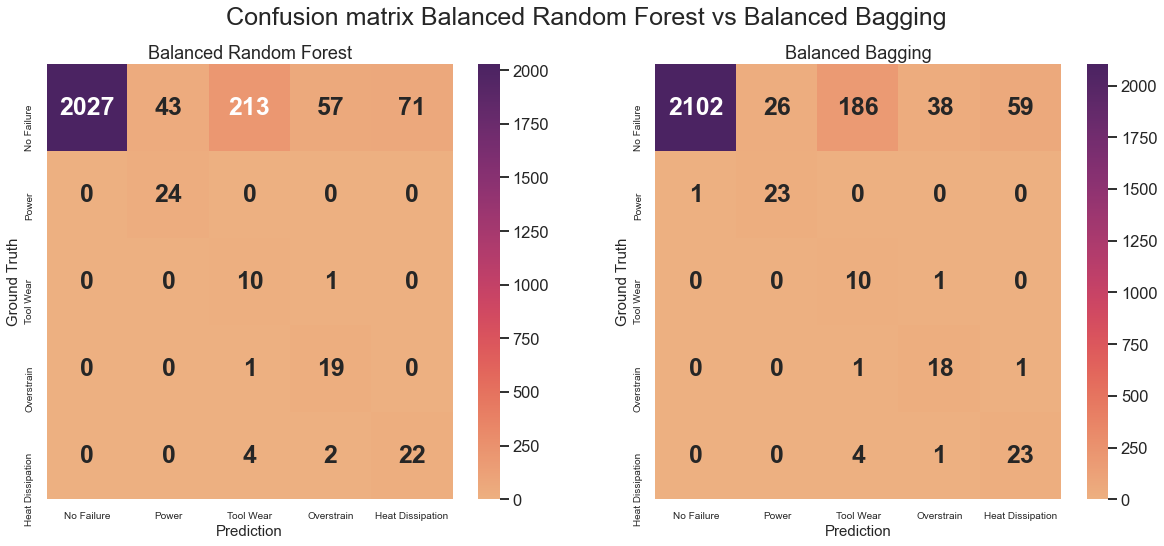

In [45]:
cm_brfc = confusion_matrix(y_test, y_pred_brfc)
cm_bbc = confusion_matrix(y_test, y_pred_bbc)

# Plotting confusion matrices
fig, ax = plt.subplots(1,2,figsize=(20,8))
ax.flatten()
fig.suptitle('Confusion matrix Balanced Random Forest vs Balanced Bagging', fontsize=25)

sns.heatmap(cm_brfc, annot=True, fmt='d', cmap='flare', annot_kws={"size": 25, "weight": "bold"}, ax=ax[0])
sns.heatmap(cm_bbc, annot=True, fmt='d', cmap='flare', annot_kws={"size": 25, "weight": "bold"}, ax=ax[1])

ax[0].set_title('Balanced Random Forest')
ax[1].set_title('Balanced Bagging')

labels =  ['No Failure',
           'Power',
           'Tool Wear',
           'Overstrain',
           'Heat Dissipation']

for i in [0,1]:
    ax[i].set_xticklabels(labels, fontsize=10);
    ax[i].set_yticklabels(labels, fontsize=10);
    ax[i].set_ylabel('Ground Truth', fontsize=15);
    ax[i].set_xlabel('Prediction', fontsize=15)

Multiclass Classification Results Interpretation

In multiclass predictive maintenance, the business problem changes from "Will it fail?" to "How will it fail?" Knowing the specific failure type allows maintenance teams to prepare the exact tools, parts, and specialized personnel, which drastically reduces repair time and cost.The classes are highly imbalanced, with 'No Failure' (Class 0.0) dominating the $2494$ test samples ($\approx 2411$ samples). The failure classes (1.0 to 4.0) are the critical minority classes (supports ranging from $11$ to $28$).

Key Metrics and Business Context

Recall (Vertical Perspective - Cost of Catastrophe): This is the fraction of actual failures of a specific type that the model correctly predicted. High Recall on failure classes is essential because a missed type of failure (FN) leads to an incorrect response, delayed repair, and higher cost.

Precision (Horizontal Perspective - Cost of False Alarms): This is the fraction of the model's predictions for a specific type that were actually correct. High Precision is essential because a low-precision prediction (FP) means the crew shows up with the wrong tools/parts, leading to wasted time and labor cost.

Macro Average (Overall Performance): This average treats all classes equally, which is crucial here because the business value of predicting one of the $11$ Tool Wear failures is far greater than the value of predicting one of the $2411$ No Failure events.

Business Takeaways

Safety is Assured (High Recall): The models are highly effective at detecting that some type of failure is about to occur (Macro Recall $\approx 90\%$). The risk of a catastrophic, completely missed failure is low.

Efficiency is the Problem (Low Precision): The low Precision is the main cost driver now. The business will pay heavily in wasted labor and downtime because the models cannot reliably tell the maintenance team what parts to bring.

Actionable Insight: Focus on Tool Wear: The abysmal Precision for Tool Wear (2.0) must be addressed. Any prediction for this class from either model is virtually useless, leading to incorrect preparation $95\%$ of the time.

Final Recommendation: The Balanced Bagging Classifier (BBC) provides the most robust solution by having the lowest off-diagonal errors (Misclassification), which directly minimizes the most common cost driver in multiclass predictive maintenance: wasted time due to preparing for the wrong type of failure.

# Recommendations

### Predictive Maintenance Modeling Strategy: Final Recommendations

We have successfully analyzed the machine data to develop a robust predictive maintenance framework targeting both binary failure prediction (Yes/No) and multiclass failure identification (Type of Failure). Our models consistently demonstrate an excellent capacity for detecting impending breakdowns, effectively shifting maintenance from reactive crisis management to proactive planning. This analysis focused heavily on minimizing the total cost to the business, recognizing that the cost of a catastrophic, unplanned failure far outweighs the cost of a false alarm or a misclassified repair job. Based on rigorous cross-validation and analysis of the $\text{F}_1$ score and confusion matrices, we have identified two superior models for immediate deployment, depending on the operational goal.

For the fundamental business objective of minimizing catastrophic unplanned downtime (the binary classification), we recommend deploying the XGBoost Classifier. Although the Support Vector Machine (SVC) achieved a slightly higher $\text{ROC AUC}$ score (a measure of theoretical potential), XGBoost provided the best Macro $\text{F}_1$ score of all models tested. This metric confirms that XGBoost offers the most practical and efficient balance between catching actual failures (high Recall) and avoiding unnecessary maintenance checks (high Precision), thereby ensuring the lowest overall operational and disaster costs. This model is ready to be integrated into your monitoring system to trigger a "Go/No Go" decision for maintenance intervention.

To advance operations and allow for specific resource allocation—which is the key to further cost reduction—we recommend using the Balanced Bagging Classifier (BBC) for multiclass failure prediction. This model identifies the specific impending failure type (e.g., Power Failure, Tool Wear, Overstrain). The BBC achieved the highest Macro $\text{F}_1$ score ($0.51$) among the specialized imbalanced learning algorithms. While its Precision on minority classes remains low (meaning it sometimes predicts the wrong type of failure), it has the lowest rate of misclassification errors compared to competitors like Balanced Random Forest. This higher reliability in identifying the correct failure type translates directly into less wasted labor, correct parts pre-ordered, and shorter repair times, offering tangible efficiency gains.

For immediate deployment, we recommend a two-stage alerting system. The XGBoost model should be used as the primary warning system; if it triggers a binary "Failure Imminent" alert, the Balanced Bagging Classifier should then be consulted to recommend the most likely failure type. We caution stakeholders that Precision is weakest for the Tool Wear failure type ($<5\%$ accuracy), and any alert for this specific type should be treated with skepticism and confirmed manually. This layered approach ensures that high safety is maintained while simultaneously improving the efficiency of the response, providing the maximum return on investment from this predictive maintenance solution.


# Next Steps

The core strategy is to implement a two-stage, cost-effective predictive maintenance system.Binary Failure Prediction (Safety First): 

The XGBoost Classifier is recommended for the primary task of detecting whether any failure is imminent ("Go/No Go" decision). This model provides the best Macro $\text{F}_1$ score, offering the optimal balance between high safety (Recall) and minimizing overall cost (Precision) compared to the SVC.

Multiclass Failure Identification (Efficiency Second): Once a failure is predicted, the Balanced Bagging Classifier (BBC) is used to identify the specific failure type (Power, Tool Wear, etc.). The BBC is chosen because its highest Macro $\text{F}_1$ score ($0.51$) and better Precision minimize operational errors (misclassifying the type of failure), leading to faster, more efficient repairs and reduced labor costs.Caution: Stakeholders are advised that the model's Precision for the Tool Wear failure type is critically low ($<5\%$ accuracy) and must be confirmed manually during deployment.

# Thank you

